# Image Classification of ATLAS Calorimeter Topo-Clusters (unsupervised)

## This is a work in progress.

In [27]:
save_data = True # whether or not to save data with classification labels applied

In [32]:
#import libraries and some constants
import os, sys, pickle, uuid, itertools, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur
from pathlib import Path
import subprocess as sub

path_prefix = os.getcwd() + '/../'
plotpath = path_prefix+'classifier_u/Plots/'
modelpath = path_prefix+'classifier_u/Models/'
for path in [plotpath,modelpath]:
    try: os.makedirs(path)
    except: pass

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import qol_util as qu # for progress bar, plot_style

# use our custom dark style for plots
dark_style = qu.PlotStyle('dark')
dark_style.SetStyle() # still need to manually adjust legends, paves

# file formats for plots
plot_formats = ['pdf','png']

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

Now let's import our resolution utilities. These take care of some plotting, using `matplotlib` and the `atlas_mpl_style` package.

In [3]:
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu

## Importing the data.

We can use either our pion gun data (`pion`) or our jet data (`jet`). For the latter, we'll stick to the files where I've tried to add labels $(\pi^\pm,\pi^0)$ but only because things are neatly in two files, and this is already some subset of the jet dataset so we don't have to worry about leaving out data for later testing / jet clustering.

Since we're performing *unsupervised classification*, we don't care about the actual labels from our data. We'll treat all topo-clusters the same as inputs, and see what we find.

Now, we will import our data from the `ROOT` files into a `pandas` DataFrame. The first cell takes care of scalars, and the second takes care of vectors.

In [4]:
# import pi+- vs. pi0 images

source = 'jet' # also try 'jet'

if(source == 'pion'):
    inputpath = path_prefix+'data/pion/'
    rootfiles = ["pi0", "piplus", "piminus"]
    branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
elif(source == 'jet'):
    inputpath = path_prefix+'jets/training/'
    rootfiles = ["pi0", "piplus"]
    branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_ENG_CALIB_TOT']
else:
    assert(False)

In [5]:
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

trees = {rfile : ur.open(inputpath+rfile+".root")['ClusterTree'] for rfile in rootfiles}
pdata = {ifile : itree.pandas.df(branches, flatten=False) for ifile, itree in trees.items()}
pcells = {ifile : {layer : mu.setupCells(itree, layer) for layer in layers} for ifile, itree in trees.items()}
keys = pdata.keys()

# Now immediately merge everything. Use of dicts explicitly ensures ordering is the same for pdata_merged and pcells_merged.
pdata_merged = pd.concat([pdata[key] for key in keys])
pcells_merged = {
    layer : np.concatenate([pcells[ptype][layer] for ptype in keys])
    for layer in layers
}

del pdata
del pcells

Now we have our data.

I'm going to roughly be following [this tutorial](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) on performing unsupervised classification. Our data is rather high-dimensional, so training encoders (via an auto-encoder setup) seems like a good idea. We can then perform clustering on the encoded data, so that it will be in a lower-dimensional space.

As a second resource, [see this repo](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb).

## Training auto-encoders.

We're going to train a set of auto-encoders -- we're really just interested in the (trained) encoders that these will yield.

We could just train a single auto-encoder that takes a combo of all the layers as input. Instead, we will train a separate auto-encoder for each layer. With each encoder that we generate, we will perform clustering (unlabeled classification), so for each topo-cluster we will yield as many soft labels as we have calorimeter layers. We can then take this set of labels, and perform clustering once more (using these as our new features).

In [6]:
# A bunch of hyper-parameters

# Global
lr = 5e-5
n_training = 10000 # number of data points to use for training encoder
demo = False

# Encoders
n_compression = 10
n_epochs = 20
verbose = 0
if(demo):
    verbose = 1
    n_epochs = 5

# Clustering
n_clusters = 4 # tunable parameter for clustering
maxiter = 800
update_interval = 100
tol = 0.001
batch_size = 200

In [7]:
# setting up and importing tensorflow
ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [8]:
# some useful keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [9]:
# this can be an encoder or decoder, depending on the relative sizes of n_input and n_output
def base_model(n_input, hidden_layers =0, n_output = 10):
    def_act = 'relu'
    if(hidden_layers == 0): hidden_layers = [int(n_input/2), int(n_input/2), n_input]
    # create model
    #with strategy.scope(): # TODO: What does the strategy do? Defined outside of function -> be careful
    model = Sequential()        
    model.add(Dense(n_input, input_dim=n_input, kernel_initializer='normal', activation=def_act))
    for n in hidden_layers:  model.add(Dense(n, activation=def_act))
    model.add(Dense(n_output, kernel_initializer='normal', activation=def_act))
    return model

def GetEncoderDecoder(n_input, hidden_layers=0, n_compression = 10):
    encoder = base_model(n_input, hidden_layers, n_compression)
    decoder = base_model(n_compression, hidden_layers, n_input)
    return encoder, decoder

In [10]:
from cluster_layer import ClusteringLayer

n_data = pcells_merged[layers[0]].shape[0]
training_indices = np.sort(np.random.choice(n_data,n_training,replace=False))
training_data = {layer: pcells_merged[layer][training_indices,:] for layer in layers}

encoders = {}
decoders = {}
codings = {}
histories = {}
encoder_weightfiles = {}
for i, layer in enumerate(layers):
    
    data = training_data[layer]
    n_input = len_eta[i] * len_phi[i]

    encoders[layer], decoders[layer] = GetEncoderDecoder(n_input, n_compression = n_compression)
    autoencoder = Sequential([encoders[layer], decoders[layer]])
    
    # check if the weights were saved, if so we skip re-training
    weight_file = layer + '_encoder.h5'
    encoder_weightfiles[layer] = weight_file
    if(Path(modelpath + weight_file).is_file()): 
        encoders[layer].load_weights(modelpath + weight_file)
    else:
        print('Layer =',layer)
        autoencoder.compile(loss = 'mse',optimizer=Adam(lr=lr))
        histories[layer] = autoencoder.fit(data,data, epochs=n_epochs,verbose=verbose)
        encoders[layer].save_weights(modelpath + weight_file)
    codings[layer] = encoders[layer].predict(data)

In [11]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, n_init=20) # TODO: what does n_init do?

models = {} # each model will be encoder + clustering
clustering_layers = {}
y_pred = {}
for i,layer in enumerate(layers):
    print('Layer:',layer)
    model_name = layer + '.h5'
    index = 0
    index_array = np.arange(training_data[layer].shape[0])
    layer_name = 'clustering_'+layer
    clustering_layers[layer] = ClusteringLayer(n_clusters,name=layer_name)(encoders[layer].output)
    models[layer] = tf.keras.Model(inputs=encoders[layer].input,outputs=clustering_layers[layer])
    
    if(Path(modelpath + model_name).is_file()):
        models[layer].load_weights(modelpath + model_name)
        continue
    
    y_pred[layer] = kmeans.fit_predict(encoders[layer].predict(training_data[layer]))
    y_pred_last = y_pred[layer]
    models[layer].get_layer(name=layer_name).set_weights([kmeans.cluster_centers_])
    models[layer].compile(loss = 'kld',optimizer=Adam(lr=lr)) # TODO: should we use different optimizer & lr than above?
    
    for ite in range(maxiter):
        if(ite % update_interval == 0):
            q = models[layer].predict(training_data[layer],verbose=0)
            p = target_distribution(q)
            y_pred[layer] = q.argmax(1)
            
            # check stop criterion
            delta_label = np.sum(y_pred[layer] != y_pred_last).astype(np.float32) / y_pred[layer].shape[0]
            y_pred_last = np.copy(y_pred[layer])
            if(ite > 0 and delta_label < tol):
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break      
                
        idx = index_array[index * batch_size: min((index+1) * batch_size, training_data[layer].shape[0])]
        loss = models[layer].train_on_batch(x=training_data[layer][idx], y=p[idx])
        if((index + 1) * batch_size <= training_data[layer].shape[0]): index = index + 1
        else: index = 0
    
    models[layer].save_weights(modelpath + model_name)

Layer: EMB1
Layer: EMB2
Layer: EMB3
Layer: TileBar0
Layer: TileBar1
Layer: TileBar2


Now we have 6 different models that will assign our topo-clusters to different categories (we chose the number of categories with a hyper-parameter at the top). Let's apply each model to the training data and get the scores.

In [13]:
model_name = 'k_means'
model_filename = model_name + '.pkl'
n_labels = 4 # in principle, we can choose a different number of clusters than we did for clustering on each layer

if(Path(modelpath + model_filename).is_file()):
    kmeans = pickle.load(open(modelpath + model_filename, 'rb'))

else:
    layer_scores = {}
    for layer in layers:
        layer_scores[layer] = models[layer].predict(training_data[layer])

    training_features = np.column_stack(tuple([layer_scores[layer] for layer in layers]))
    kmeans = KMeans(n_clusters=n_labels, n_init=8)
    kmeans.fit(training_features)

    # saving our k-means model
    pickle.dump(kmeans, open(modelpath + model_name + '.pkl', 'wb'))

## Evaluating on our data

Now that we have our networks, and the k-means clustering that combines their outputs, we can evaluate this workflow on some data.

Note that unlike our regular classifier, this isn't a single model. Thus we don't just have a single `HDF5` file with weights and a model that we can load for evaluation. Our evaluation will require loading a set of models from `HDF5` and `pickle` files.

In [14]:
# now get our results for all data
layer_scores_full = {layer: models[layer].predict(pcells_merged[layer]) for layer in layers}
features_full = np.column_stack(tuple([layer_scores_full[layer] for layer in layers]))
results_full = kmeans.predict(features_full)

### Plotting

Let's make some plots of our network scores -- the labels of categories into which our topo-clusters fall -- versus a few different kinematic variables.

For each plot, we will normalize each category bin so that they have the same integral -- we may find many more events falling into one cluster versus another, but we're interested in comparing shapes. Does one category correspond to low-energy events? Or some other easily-observable feature?

In [15]:
def RN():
    return str(uuid.uuid4())

Info in <TCanvas::Print>: pdf file /local/home/jano/ml4pions/LCStudies/classifier_u/../classifier_u/Plots/cluster_scores.pdf has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/classifier_u/../classifier_u/Plots/cluster_scores.png has been created


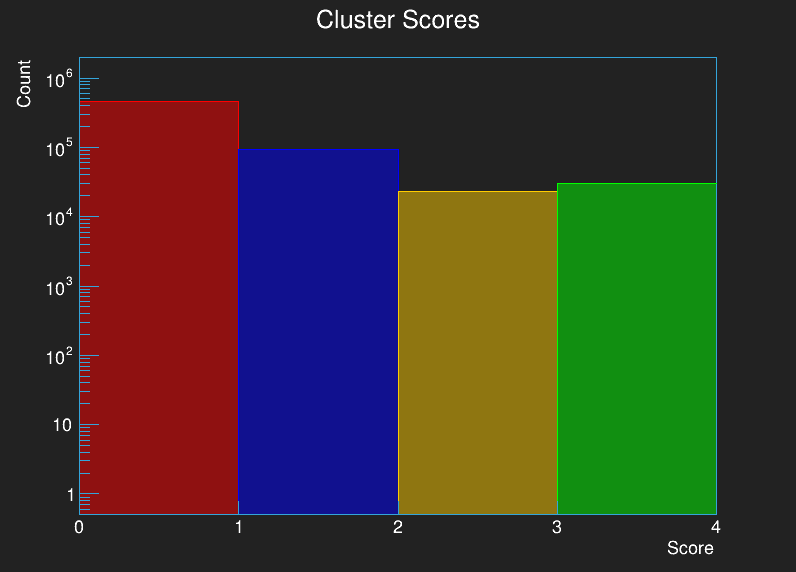

In [16]:
rt.gStyle.SetOptStat(0)

colors = [rt.kRed, rt.kBlue, rt.kOrange, rt.kGreen, rt.kCyan, rt.kViolet]
assert(len(colors) >= n_labels)
hists = []
stack = rt.THStack()
c = rt.TCanvas(RN(),'c0',800,600)

for i in range(n_labels):
    h = rt.TH1I(RN(),'',n_labels,0,n_labels)
    h.SetLineColor(colors[i])
    h.SetFillColorAlpha(colors[i],0.5)
    hists.append(h)
    
for entry in results_full: hists[int(entry)].Fill(entry)
rt.gPad.SetLogy()
for h in hists: stack.Add(h)
stack.Draw('NOSTACK HIST')
stack.SetTitle('Cluster Scores')
stack.GetXaxis().SetTitle('Score')
stack.GetYaxis().SetTitle('Count')
stack.GetXaxis().SetNdivisions(-n_labels)
stack.SetMinimum(5.0e-1)
stack.SetMaximum(2.0e6)
c.Draw()
for pf in plot_formats:
    c.SaveAs(plotpath + 'cluster_scores' + '.' + pf)

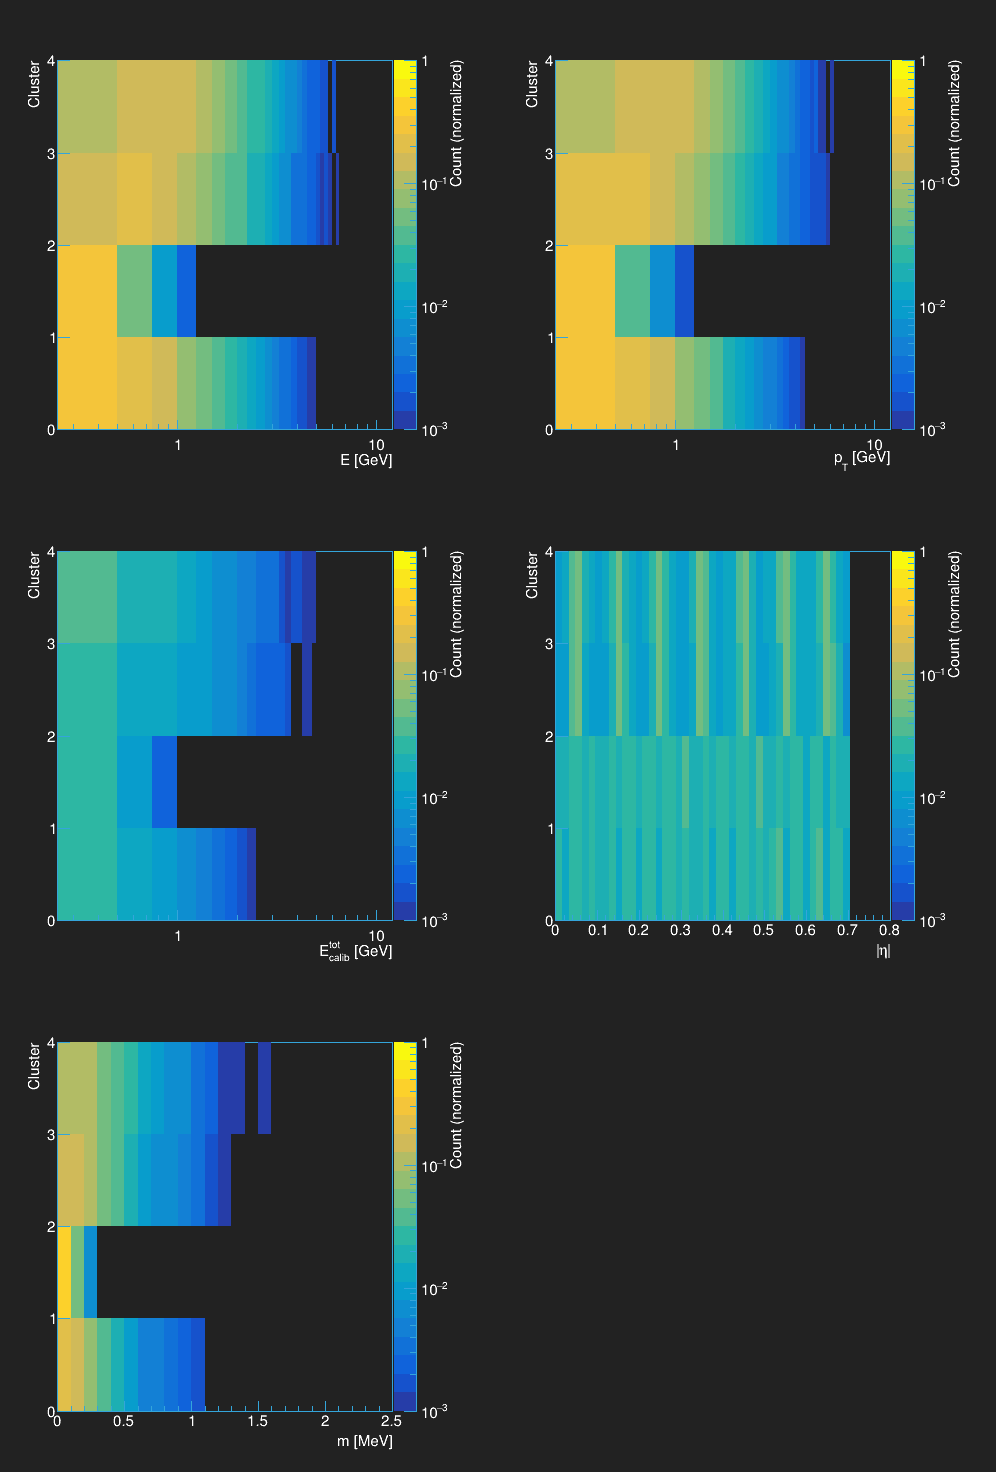

In [17]:
rt.gStyle.SetOptStat(0)
rt.gErrorIgnoreLevel = rt.kWarning

# let's plot the scores versus a few different variables
plot_vars = ['clusterE','clusterPt','cluster_ENG_CALIB_TOT','clusterEta','clusterM']

var_info = {}
var_info['clusterE']              = {'name':'E [GeV]'              , 'range':(0.,12.),   'nbins':48, 'logx':True}
var_info['clusterPt']             = {'name':'p_{T} [GeV]'          , 'range':(0.,12.),   'nbins':48, 'logx':True}
var_info['cluster_ENG_CALIB_TOT'] = {'name':'E_{calib}^{tot} [GeV]', 'range':(0.,12.),   'nbins':48, 'logx':True}
var_info['clusterEta']            = {'name':'|#eta|'               , 'range':(0.,.8),    'nbins':50, 'logx':False}
var_info['clusterM']              = {'name':'m [MeV]'              , 'range':(0.,2.5),   'nbins':25, 'logx':False}

# prepare the plotting variables themselves, many are just read from dataframe
var_list = {}
for key in ['clusterE','clusterPt','cluster_ENG_CALIB_TOT','clusterEta','clusterPhi']:
    var_list[key] = pdata_merged[key].to_numpy()

# get the mass -- this is a bit more complicated
nentries = len(var_list['clusterE'])
var_list['clusterM'] = np.zeros(nentries)
vec = rt.Math.PtEtaPhiEVector()
for i in range(nentries):
    vec.SetCoordinates(var_list['clusterPt'][i], var_list['clusterEta'][i], var_list['clusterPhi'][i], var_list['clusterE'][i])
    var_list['clusterM'][i] = vec.M() * 1000. # converting from GeV to MeV
# turn eta -> abs(eta)
var_list['clusterEta'] = np.abs(var_list['clusterEta'])

plot_size = 500
n_plots = len(plot_vars)
nx = 2
ny = int(np.ceil(n_plots/nx))
c = rt.TCanvas(RN(),'c1',nx * plot_size, ny * plot_size)
c.Divide(nx,ny)
n = len(results_full)
hists = []
for i in range(n_plots):
    var_name = plot_vars[i]
    var = var_list[var_name]
    
    plot_title = ';' + var_info[var_name]['name'] + ';Cluster;Count (normalized)'
    xi,xf,nbins = var_info[var_name]['range'][0],var_info[var_name]['range'][1],var_info[var_name]['nbins']
    h = rt.TH2F(RN(), plot_title, nbins, xi, xf, n_labels, 0, n_labels)
    for j in range(n): h.Fill(var[j],results_full[j])
        
    # now we want to perform row-normalization of our histogram
    for j in range(1,n_labels+1):
        integral = h.Integral(0,nbins, j,j)
        for k in range(1, nbins+1): h.SetBinContent(k,j,h.GetBinContent(k,j) / integral)
        
    # make a "mini canvas" for saving to file (but not for display in notebook)
    mini_canvas = rt.TCanvas(RN(),'mini',plot_size,plot_size)
    canv_choices = [(c,i+1),(mini_canvas,0)]
    for canv, c_idx in canv_choices:
        canv.cd(c_idx)        
        h.Draw('COLZ')
        h.SetMaximum(1.)
        h.GetXaxis().SetTitleOffset(1.2)
        h.GetZaxis().SetTitleOffset(1.5)
        h.GetYaxis().SetNdivisions(-(n_labels))
        
        rt.gPad.SetRightMargin(0.2)
        if(var_info[var_name]['logx']): rt.gPad.SetLogx()
        rt.gPad.SetLogz()
        if(c_idx == 0):
            for pf in plot_formats: canv.SaveAs(plotpath + var_name + '.' + pf)
    hists.append(h)

c.Draw()

Perhaps unsurprisingly, there aren't any super-obvious trends in these $2D$ plots. We see that the $2^\text{nd}$ label lacks cluster at higher energies, compared to the others, but I don't see any other obvious patterns here.

Since we have a small number of categories, in principle we could look for higher-order correlations between category and variable by making 3D scatter plots of the data points. We could achieve the third dimension visually by color, as we only have a few different categories to consider.

Since the point clouds will be very dense -- and it may be hard to see patterns if they overlap a lot -- we will constrain the number of points:
    
    - We will ensure that we draw the same number of points per category, by selecting a number of points from each category corresponding with the size of the smallest category.
    
    - For each point, we will randomly choose whether or not to draw it -- further reducing the number of points.

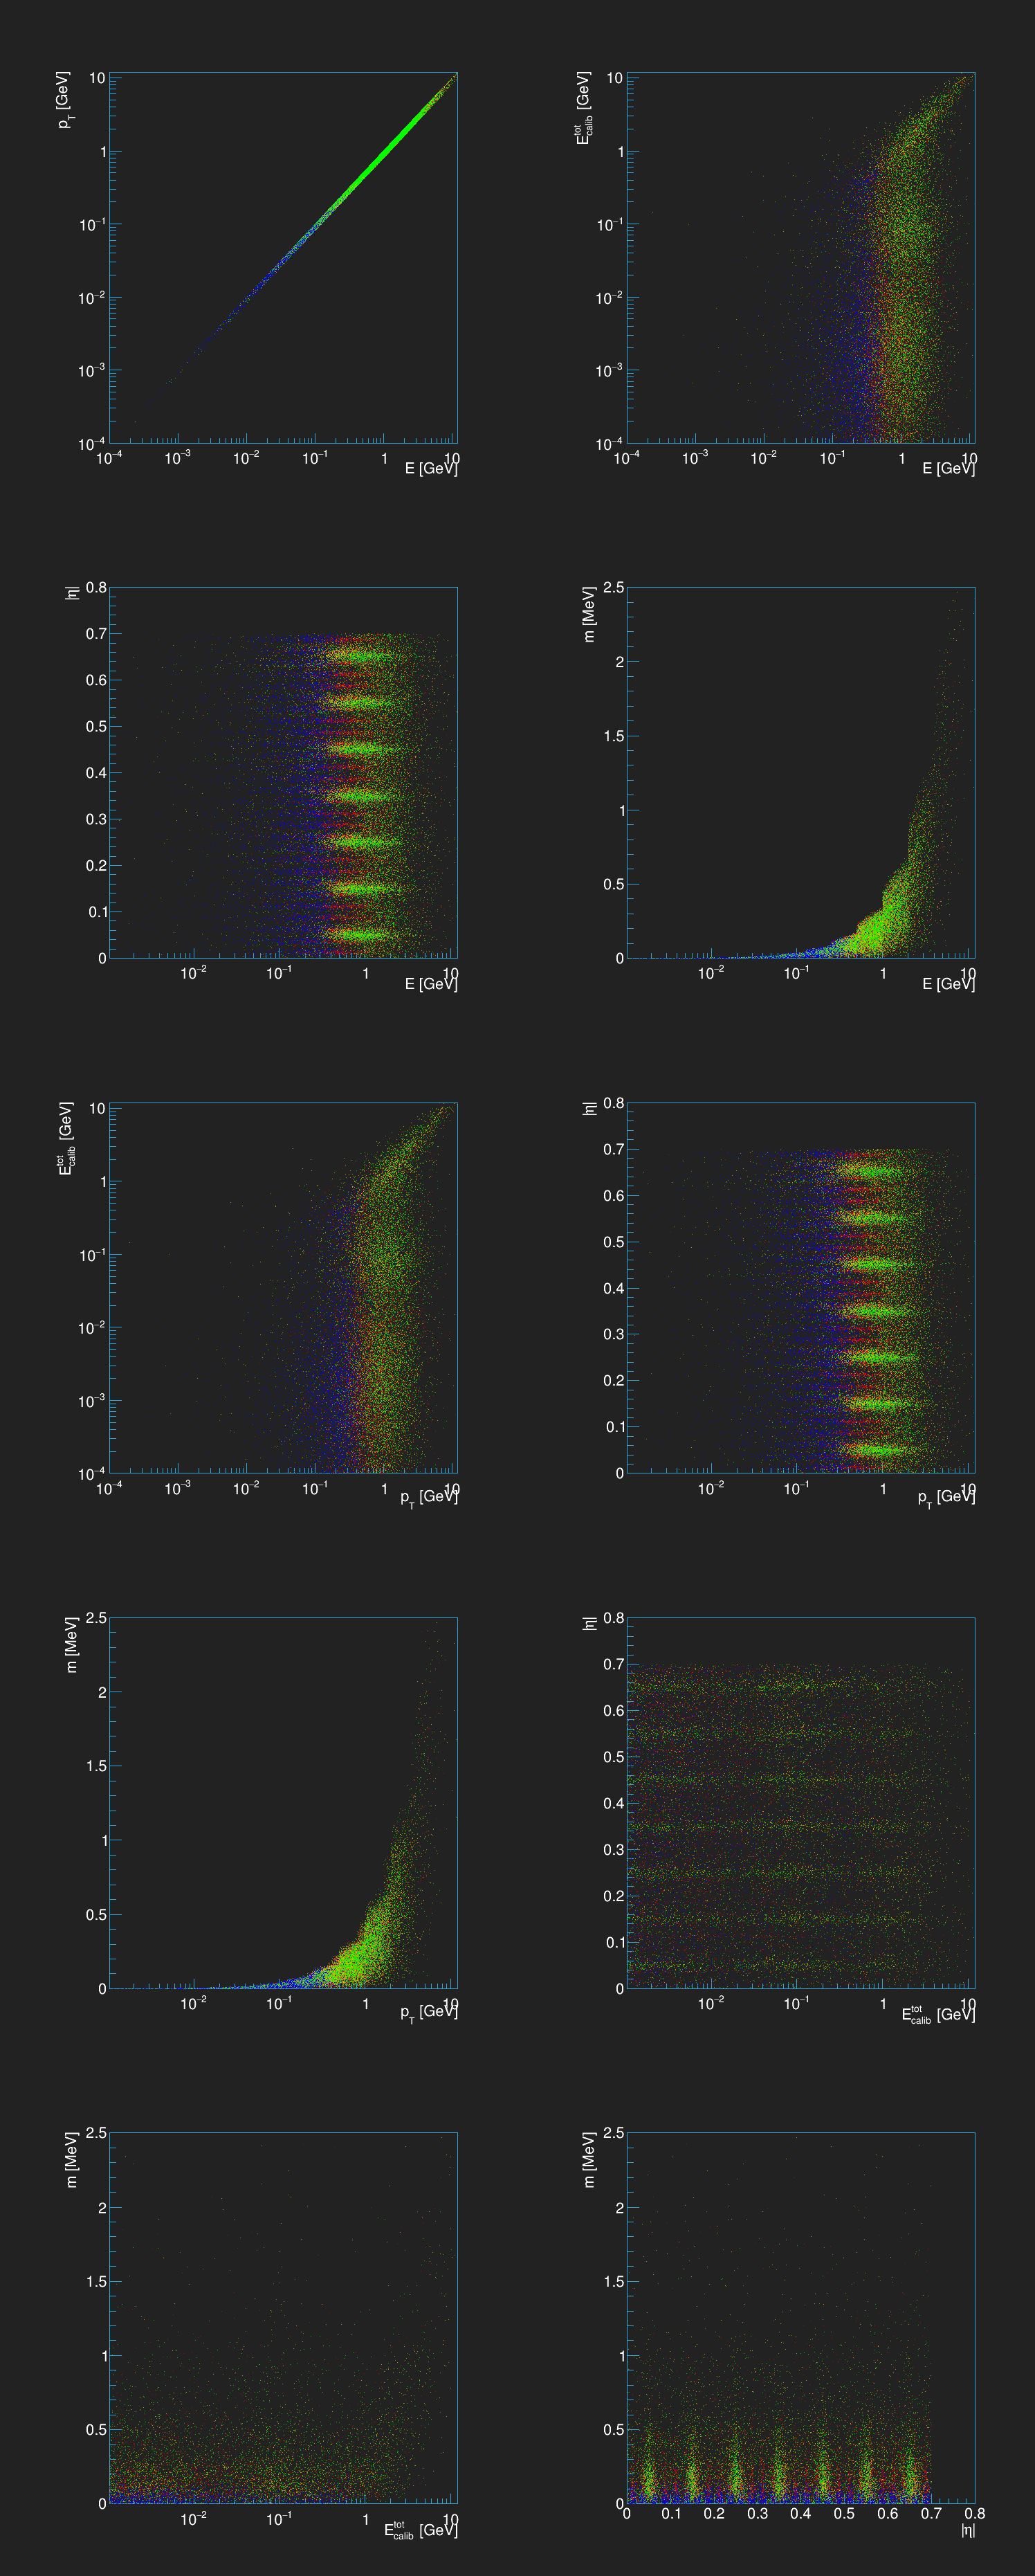

In [18]:
big_markers = False

if(big_markers):
    suppression = 0.005
    alpha = 0.4
    marker_style = rt.kFullCircle
    marker_size = 0.5
else:
    suppression = 0.5 # what fraction of points to draw
    alpha = 0.7
    marker_style = rt.kDot
    marker_size = 1.
    
var_combos = list(itertools.combinations(plot_vars, 2))
plot_size = 750
nx = 2
ny = int(np.ceil(len(var_combos)/nx))
c = rt.TCanvas(RN(),'c2', plot_size * nx, plot_size * ny)
c.Divide(nx,ny)

graphs = []
multigraphs = []

# determine the indices of points that we will draw
unique, counts = np.unique(results_full, return_counts=True)
new_max = int(suppression * np.min(counts))
indices = np.array(range(len(results_full)))[results_full.argsort()]
draw_indices = []
for i in range(len(counts)):
    if(i == 0): 
        selected_indices = indices[0:counts[i]]
    else:
        s = np.sum(counts[:i])
        selected_indices = indices[s:s+counts[i]]        
    selected_indices = np.random.choice(selected_indices, new_max, replace=False)
    draw_indices.append(selected_indices)
draw_indices = np.array(draw_indices).flatten()

for i, combo in enumerate(var_combos):
    c.cd(i+1)
    varname1, varname2 = combo
    var1 = var_list[varname1]
    var2 = var_list[varname2]
    
    # we want a separate graph for each label
    scatters = []
    for j in range(n_labels): 
        scatters.append(rt.TGraph())
        scatters[j].SetMarkerColorAlpha(colors[j],alpha)
        scatters[j].SetMarkerStyle(marker_style)
        scatters[j].SetMarkerSize(marker_size)
        
    for j in draw_indices: scatters[int(results_full[j])].SetPoint(scatters[int(results_full[j])].GetN(),var1[j],var2[j])        
    mg = rt.TMultiGraph()
    mg.SetTitle(';' + var_info[varname1]['name'] + ';' + var_info[varname2]['name'])
    for scatter in scatters:
        graphs.append(scatter)
        mg.Add(scatter)
    
    mg.Draw('AP')
    rt.gPad.Modified() # still not sure what this does, after all these years...
    xi, xf = var_info[varname1]['range']
    yi, yf = var_info[varname2]['range']
    mg.GetXaxis().SetLimits(xi, xf)
    mg.SetMinimum(yi)
    mg.SetMaximum(yf)
    
    if(var_info[varname1]['logx']): rt.gPad.SetLogx()
    if(var_info[varname2]['logx']): 
        mg.SetMinimum(1.0e-4)
        mg.GetXaxis().SetLimits(1.0e-4,xf)
        rt.gPad.SetLogy()
        
    rt.gPad.SetLeftMargin(0.2)
    multigraphs.append(mg)
    
c.Draw()

Again, it's hard to tell exactly if we're seeing the results of some markers just overlapping others or not, but it looks like there might be *some* kind of patterns here.

For the purposes of training our energy regressions, we should save a copy of the data with the labels applied. This includes the training data for the classification, and whatever other events are in the files -- we can use all of this for training the regressions (or still set aside some events for validation).

In [36]:
outfile_name = 'clusters.root'
tree_name = 'ScoreTree'
# reusing "keys" from before, to piece results back together without recalc'ing
files = [inputpath + key + '.root' for key in keys]
datapath = os.getcwd() + '/data/'
try: os.makedirs(datapath)
except: pass

buffer = np.zeros(1,dtype=np.dtype('i2'))

# make copies of our input data - ordering of keys gives order in which data is concatenated in results_full
start = 0
for key in keys:
    if(not save_data): continue
    oldfile = inputpath + key + '.root'
    newfile = datapath + key + '.root'
    sub.check_call(['cp',oldfile,newfile])
    
    # now open the new file, and add a new tree
    f = rt.TFile(newfile,'UPDATE')    
    t = rt.TTree(tree_name,tree_name)
    branch = t.Branch('category',buffer,'category/S')
    nentries = f.Get('ClusterTree').GetEntries()
    for i in range(nentries):
        buffer[0] = results_full[start + i]
        t.Fill()
    
    t.Write()
    start += nentries
    f.Close()
    
# hadd our results together -- for regression, we don't care if things are pi0 or piplus/piminus
oldfiles = glob.glob(datapath + '*.root')
sub.check_call('hadd ' + datapath + outfile_name + ' ' + datapath + '*.root',shell=True)
for file in oldfiles: sub.check_call(['rm',file])

hadd Target file: /local/home/jano/ml4pions/LCStudies/classifier_u/data/clusters.root
hadd compression setting for all output: 1
hadd Source file 1: /local/home/jano/ml4pions/LCStudies/classifier_u/data/pi0.root
hadd Source file 2: /local/home/jano/ml4pions/LCStudies/classifier_u/data/piplus.root
hadd Target path: /local/home/jano/ml4pions/LCStudies/classifier_u/data/clusters.root:/


Now we can check that our output looks okay.

In [35]:
f = rt.TFile(datapath + outfile_name,'READ')
t1 = f.Get('ClusterTree')
t2 = f.Get(tree_name)
assert(t1.GetEntries() == t2.GetEntries())
f.Close()